In [3]:
#we want to define two functions: one to get the IoU, one to get the average time per image compared to cellpose

from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np

import matplotlib.pyplot as plt

In [88]:
#import model
unet = UNet(encChannels=(1, 32, 64), decChannels=(64, 32))
unet = unet.to('cuda:0')
unet.load_state_dict(torch.load('C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\models\\model12'))

<All keys matched successfully>

In [83]:
#get testing images

cellpose_model_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cellpose_model = getModel(cellpose_model_directory)

images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)
testing_images = images[5:10]
testing_probability_maps, testing_cell_masks = makePredictions(testing_images, cellpose_model)

a
a
a
a
a


In [89]:
#get predictions (calculate time taken per image and average)

predictions = []
times = []
for (k, image) in enumerate(testing_images):
    x = torch.from_numpy(image)
    x = x.unsqueeze(0)
    x = x.unsqueeze(0)
    x = x.to('cuda:0')
    start = time.time()
    prediction = unet(x)[1]
    end = time.time()
    times.append(end-start)
    prediction = torch.sigmoid(prediction)
    prediction = prediction.squeeze(0)
    prediction = prediction.squeeze(0)
    prediction = prediction.cpu().detach().numpy().tolist()
    prediction = cv2.resize(np.array(prediction), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    prediction = np.array(prediction)
    predictions.append(prediction)

In [90]:
print(times)

[0.0029900074005126953, 0.0019943714141845703, 0.0019910335540771484, 0.0009958744049072266, 0.0019927024841308594]


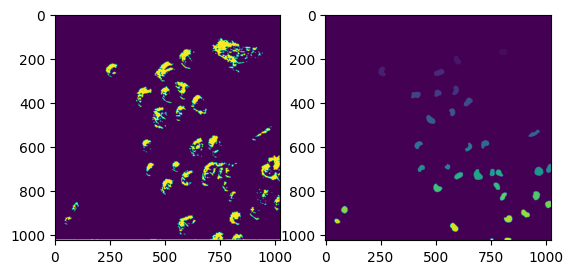

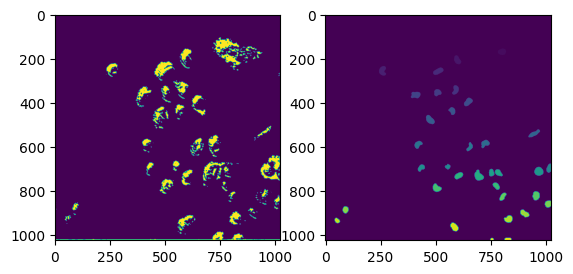

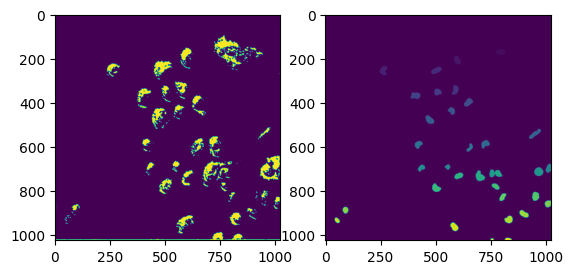

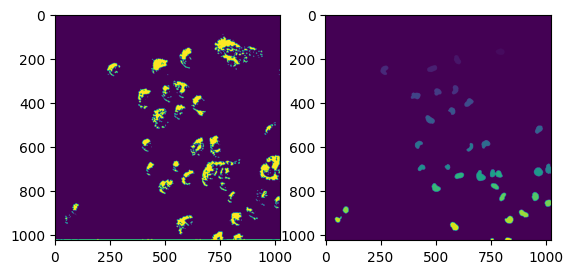

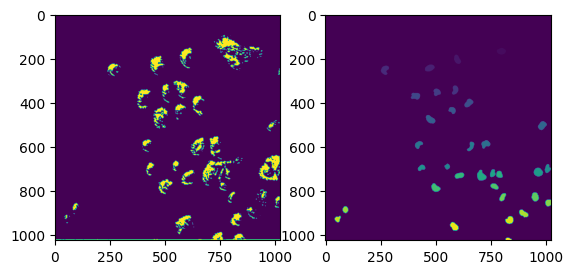

In [94]:
for i in range(len(predictions)):
    y = predictions[i]
    y_binary = np.where(y > 0.03, 1, 0)
    plt.subplot(1,2,1)
    plt.imshow(y_binary)
    plt.subplot(1,2,2)
    plt.imshow(testing_cell_masks[i])
    plt.show()

In [93]:
#get IoU

def getIoU(prediction, cellmask):
    intersection = np.logical_and(prediction, cellmask)
    union = np.logical_or(prediction, cellmask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

for j in range(0,50,1):
    thresh = j/100
    ious = []
    for i in range(len(predictions)):
        y_binary = np.where(predictions[i] > thresh, 1, 0)
        iou = getIoU(y_binary, testing_cell_masks[i])
        ious.append(iou)

    print(thresh, ious)

0.0 [0.026017189025878906, 0.026142120361328125, 0.026363372802734375, 0.02660655975341797, 0.026758193969726562]
0.01 [0.026017213837827527, 0.026142319811399927, 0.02636359908332038, 0.02660712855120952, 0.0267561813999092]
0.02 [0.02541263071889186, 0.02550803210934741, 0.025711716424607033, 0.02589698314184514, 0.026055925798957037]
0.03 [0.10640459139621108, 0.1082062546821235, 0.11095133580564595, 0.10969709849611842, 0.10920152091254753]
0.04 [0.046797309154723604, 0.04786955763529617, 0.045082680591818976, 0.042441309157782825, 0.03979629788573227]
0.05 [0.005777948030390091, 0.005751326618156398, 0.0052030776992936425, 0.005502407303195148, 0.004881689002207643]
0.06 [0.0032297262727040165, 0.0033121019108280254, 0.002970735098919158, 0.0029469856099319687, 0.0018076419622265162]
0.07 [0.0033385118831190295, 0.0034231921266581087, 0.003069588218006074, 0.003044238616490705, 0.0018674136321195146]
0.08 [0.003455945252352438, 0.003542234332425068, 0.003176104879037708, 0.0031496